<a href="https://colab.research.google.com/github/blackbaba980/GameOfThronesPredictions/blob/main/code/GameOfThronesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx



import math
import time

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 7
#set the random seeds 
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)



/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preprocessing


In [2]:
#per season adjaceny matrix, features of every node

WEIGHTS_DIV = 20

def load_data(season_no):

  #read the edge and node files
  dir = "./../data/nodes_edges/"
  edge_file = dir + "got-s" + str(season_no) + "-edges.csv"
  node_file = dir + "got-s" + str(season_no) + "-m-nodes.csv"

  edges = pd.read_csv(edge_file)
  nodes = pd.read_csv(node_file)
  
  
  #only get those edges where the nodes are present
  node_ids = nodes['CHARACTERS ID']
  node_ids_reverse = node_ids.to_dict()
  node_ids = {v: k for k, v in node_ids_reverse.items()}
  
  #remove unnecessary columns
  features = nodes.drop(['CHARACTERS ID'], axis=1)
  features = torch.from_numpy(features.to_numpy().astype(np.float32))
  torch.where(features)
  edges = edges.drop(['Season'], axis=1)
  
  #Adjacency matrix
  gr = nx.Graph()
  adj = np.zeros( (len(node_ids),len(node_ids)) )

  for i in range(len(edges)):
    if edges.iloc[i]['Source'] in node_ids and edges.iloc[i]['Target'] in node_ids:
      src_index = node_ids[edges.iloc[i]['Source']]
      dst_index = node_ids[edges.iloc[i]['Target']]
      gr.add_edge(src_index, dst_index, weight=int(edges.iloc[i]['Weight']/WEIGHTS_DIV))
      adj[src_index][dst_index] = int(edges.iloc[i]['Weight']/WEIGHTS_DIV)
      adj[dst_index][src_index] = int(edges.iloc[i]['Weight']/WEIGHTS_DIV)


  adj = torch.from_numpy(adj.astype(np.float32))
  print("adj max is {}".format(adj.max()))

  return features, adj, gr, node_ids




# Per Season Graph

In [4]:
per_season_graph = []
per_season_adj = []
per_season_nodes = []
per_season_features = []
per_season_pyg_graph = []
per_season_normalized_adj = []

def normalize_adj(adj):
    return adj / adj.sum()

for i in range(1,9):
    features, adj, graph, node_ids = load_data(i)
    per_season_graph.append(graph)
    per_season_adj.append(adj)
    per_season_nodes.append(node_ids)
    per_season_features.append(features)
    per_season_pyg_graph.append(from_networkx(graph))
    per_season_normalized_adj.append(normalize_adj(adj))
    

adj max is 9.0
adj max is 8.0


KeyError: 'CHARACTERS ID'

# Generative Model

In [98]:
class GraphConvolution(Module):
  def __init__(self, in_features, out_features, bias=True):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(in_features, out_features))
    if bias:
        self.bias = Parameter(torch.FloatTensor(out_features))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output = torch.mm(adj, support)
    if self.bias is not None:
        return output + self.bias
    else:
        return output

  def __repr__(self):
    return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'

In [752]:
class Encoder(nn.Module):
  def __init__(self, nfeat, nhid, nclass):
    super(Encoder, self).__init__()

    self.conv = GraphConvolution(nfeat, nhid)


    self.mean_finder = GraphConvolution(nhid, nhid)
    self.logstd_finder = GraphConvolution(nhid, nhid)  

    self.mean_process = nn.Linear(42*nhid,nclass)
    self.std_process = nn.Linear(42*nhid,nclass)  

    self.nhid = nhid
    self.nclass = nclass

    

  def forward(self, x, adj, save_embeddings = False):
    x = F.relu(self.conv(x, adj))


    self.mean = F.relu(self.mean_finder(x, adj))
    self.mean = self.mean_process(torch.flatten(self.mean).reshape(1,42*self.nhid))


    self.logstd = F.relu(self.logstd_finder(x, adj))
    self.logstd = torch.exp( self.std_process(torch.flatten(self.logstd).reshape(1,42*self.nhid)) )
    
    gaussian_noise = torch.randn_like(self.mean)
    sampled_z = gaussian_noise*self.logstd + self.mean
    return sampled_z

  def kl_div(self):
    kl = -0.5 * torch.mean(
            torch.sum(1 + 2 * self.logstd - self.mean**2 - self.logstd.exp()**2, dim=1))
    return kl

  def kl_loss(self):

    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * self.logstd - self.mean**2 - self.logstd.exp()**2, dim=1))

    # Limit numeric errors
    
    return kl_div
    

In [753]:
from torch_geometric.nn.models import InnerProductDecoder, VGAE



class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim):
    super(Decoder, self).__init__()
    #self.decoder = InnerProductDecoder()

    self.linear1 = nn.Linear(latent_dim, latent_dim)
    self.t = int( ( (42 * 42) - 42 ) / 2)


    #node attributes
    self.node_death = nn.Linear(latent_dim, 42)
    self.node_king  = nn.Linear(latent_dim, 42)
    self.node_war   = nn.Linear(latent_dim, 42)

    #adjacency 
    self.adjacency_finder = nn.Linear(latent_dim, self.t)

    #edge type (lets put them into 10 groups)
    
    self.edge_layer_1 = nn.Linear(latent_dim, self.t)
    self.edge_layer_2 = nn.Linear(1, 10)
    #flattent it



    #42 x 20 => 42 x 20 => (42 * 200) -> 42 of them
  

  def decode(self, x):
    x = F.relu(self.linear1(x))
    death = F.sigmoid(self.node_death(x))
    war = F.sigmoid(self.node_war(x))
    king = F.sigmoid(self.node_king(x))

    #adjacency
    adj = F.sigmoid(self.adjacency_finder(x))

    #edge type
    y = F.relu(self.edge_layer_1(x))
    y = y.reshape(self.t, 1)
    y = F.softmax(self.edge_layer_2(y))

    return death, war, king, adj, y





In [754]:
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops

class DeepVGAE(nn.Module):
  def __init__(self):
    super(DeepVGAE, self).__init__()
    self.encoder = Encoder(nfeat=10, nhid=10, nclass=10)
    self.decoder = Decoder(10,200)


  def do_it(self, x, adj):
    z = self.encoder(x, adj)
    self.kl_loss = self.encoder.kl_div()
    death, war, king, adj, y = self.decoder.decode(z)
    return death, war, king, adj, y


In [755]:

def get_class(up):
    return int(up / 20)
    

def get_the_upper(actual_adj):
    upper_size = int( ( (42 * 42) - 42 ) / 2)
    uppers = torch.zeros((upper_size, 1))


    k = 0
    for i in range(42-1):
        for j in range(i+1, 42):
            uppers[k][0] = actual_adj[i][j]
            k += 1

    for i in range(upper_size):
        uppers[i][0] = get_class(uppers[i])
    return uppers

def losses(death, war, king, adj, y, actual_features, actual_adj):

    l1 = torch.binary_cross_entropy_with_logits(king, actual_features[:,7].reshape(1,42)).sum() 
    l2 = torch.binary_cross_entropy_with_logits(death, actual_features[:,8].reshape(1,42)).sum() 
    l3 = torch.binary_cross_entropy_with_logits(war, actual_features[:,9].reshape(1,42)).sum() 



    uppers = get_the_upper(actual_adj)
    upper_size = int( ( (42 * 42) - 42 ) / 2)

    w1 = torch.autograd.Variable(upper_size/sum(torch.where(uppers > 0, 1.0, 0.0)))
    w2 = torch.autograd.Variable(upper_size/sum(uppers))
    bce = torch.nn.BCEWithLogitsLoss(pos_weight=w1)
    l4 = F.binary_cross_entropy_with_logits(adj.reshape(adj.shape[1],1), torch.where(uppers > 0, 1.0, 0.0)).sum()  


    CEL = torch.nn.CrossEntropyLoss() 
    l5 = CEL(adj.reshape(adj.shape[1],1), uppers).sum() 

    return l1+l2+l3+l4+l5






In [756]:
model = DeepVGAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
    

In [757]:
#One training step
from tqdm import tqdm


#Give the input graph to the VGAE
overall_loss = []
reconstruction_loss = []
kl_loss = []

EPOCHS = 1000
model.train()
for epoch in tqdm(range(EPOCHS)):
    for i in range(6):

        optimizer.zero_grad()
        #Inference
        death, war, king, adj, y = model.do_it(per_season_features[i], per_season_normalized_adj[i])

        
        
        #find reconstruction loss
        loss = losses(death, war, king, adj, y,per_season_features[i+1], per_season_adj[i+1])
        reconstruction_loss.append(loss.clone().detach().numpy())

        #find kl loss
        kl_divergence = 0.4 * model.kl_loss
        
        kl_loss.append(kl_divergence.clone().detach().numpy())

        #add recon_loss + kl_loss
        loss += kl_divergence
        overall_loss.append(loss.clone().detach().numpy())


        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/var/folders/dd/s4g963nd5jq4rd0szl1w4_hr0000gn/T/ipykernel_9575/2976122535.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.edge_layer_2(y))
100%|██████████| 1000/1000 [02:32<00:00,  6.54it/s]


# Analysis

In [772]:



def draw_graph(G):

    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    H = G.subgraph(largest_component)

    # compute centrality
    centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

    # compute community structure
    # lpc = nx.community.label_propagation_communities(H)
    lpc = nx.community.greedy_modularity_communities(H, weight='weight', resolution=2)
    # lpc = nx.community.girvan_newman(H)

    community_index = {n: i for i, com in enumerate(lpc) for n in com}

    #### draw graph ####
    fig, ax = plt.subplots(figsize=(20, 15))
    pos = nx.spring_layout(H, k=0.15, seed=4572321)
    node_color = [community_index[n] for n in H]
    node_size = [v * 20000 for v in centrality.values()]

    node_ids_reverse = {v: k for k, v in node_ids.items()}
    sub_nodes = {n:node_ids_reverse[n] for n in list(H.nodes())}

    nx.draw_networkx(
        H,
        pos=pos,
        with_labels=True,
        node_color=node_color,
        node_size=node_size,
        edge_color="gainsboro",
        alpha=0.5,
        labels=sub_nodes,
        font_size=14
    )

    # Resize figure for label readibility
    fig.tight_layout()
    plt.axis("off")
    plt.show()




In [ ]:
def ranking(G, n_rank):
    def get_ranking(G, n_rank):
        dc = dict(G.degree())
        wdc = dict(G.degree(weight='weight'))
        ec = nx.eigenvector_centrality(G, weight='weight')
        pg = nx.pagerank(G, weight='weight')
        bc = nx.betweenness_centrality(G, k=10, endpoints=True, weight=None)
        for n in G.nodes():
            ec[n] = round(ec[n], 3)
            pg[n] = round(pg[n], 3)
            bc[n] = round(bc[n], 3)

        dict_list = [dc, wdc, ec, pg, bc]
        # ranking_list = []
        ranking = {}
        for d in dict_list:
            sorted_dict = sorted(d.items(), key = lambda item: item[1], reverse = True)
            sorted_array = np.array(sorted_dict)
            # ranking_list += [sorted_array]
            
            ranked_nodes = sorted_array[0:(n_rank+5)][:, 0]
            for n in ranked_nodes:
                if n not in ranking:
                    ranking[int(n)] = 1
                else:
                    ranking[int(n)] = ranking[int(n)] + 1
        
        sorted_ranking = sorted(ranking.items(), key = lambda item: item[1], reverse = True)
        sorted_ranking = np.array(sorted_ranking)
        ranking = sorted_ranking[0:n_rank][:, 0]

        return ranking, dict_list

    degree = []
    weighted_degree = []
    eigenvector = []
    pagerank = []
    betweenness = []

    ranked_nodes, centrality_list = get_ranking(per_season_graph[7], 10)
    for n in ranked_nodes:
        degree += [centrality_list[0][n]]
        weighted_degree += [centrality_list[1][n]]
        eigenvector += [centrality_list[2][n]]
        pagerank += [centrality_list[3][n]]
        betweenness += [centrality_list[4][n]]

    node_ids_reverse = {v: k for k, v in node_ids.items()}
    ranked_nodes_name = [node_ids_reverse[n] for n in ranked_nodes]

    ranking_dict = {'Node': ranked_nodes_name,
                    'Degree': degree,
                    'Weighted Degree': weighted_degree,
                    'Eigenvector': eigenvector,
                    'Pagerank': pagerank,
                    'Betweenness': betweenness}

    df_ranking = pd.DataFrame(ranking_dict)

    plot = df_ranking.plot(kind='bar', figsize=(4,12),fontsize=10, subplots=True, legend=None)
    for p in plot:
        # p.set_xticks(df_ranking.index)
        p.set_xticklabels(df_ranking['Node'], rotation=45)
    plt.show()


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/var/folders/dd/s4g963nd5jq4rd0szl1w4_hr0000gn/T/ipykernel_9575/2976122535.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.edge_layer_2(y))


tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)
tensor(6)


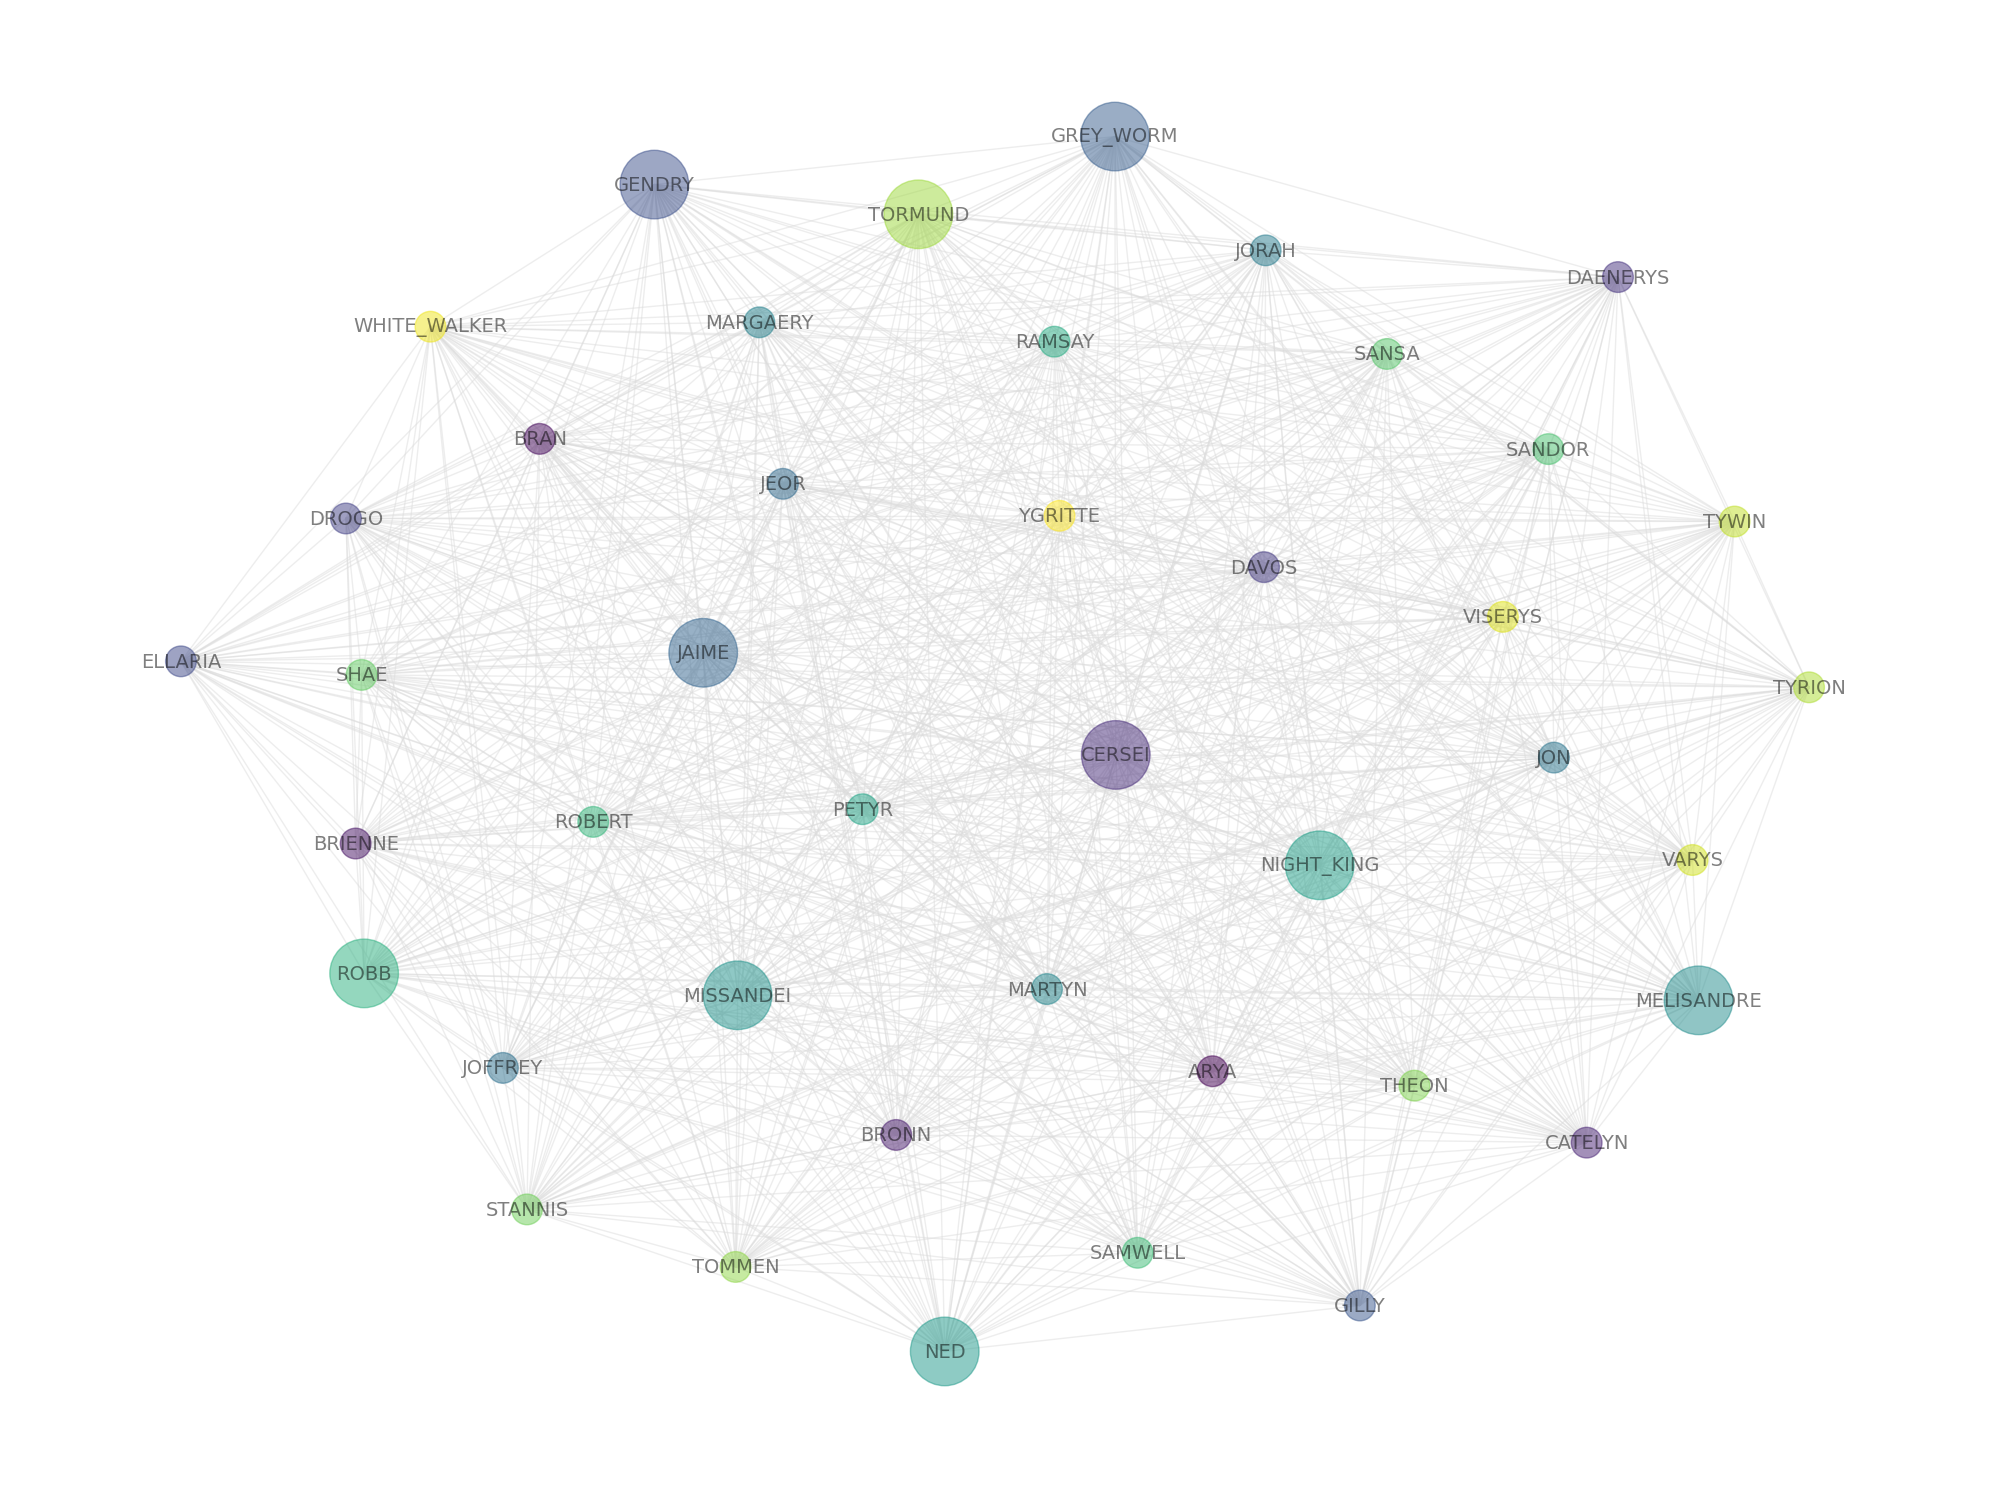

In [776]:
z = model.encoder(per_season_features[0], per_season_normalized_adj[0])
z = z + torch.randn_like(z)

############
death, war, king, adj, y = model.decoder.decode(z)

#The adjacency is the upper traingle only



def upper_to_graph(y):
    upper_size = int( ( (42 * 42) - 42 ) / 2)

    G = nx.Graph()
    k = 0
    for i in range(42-1):
        for j in range(i+1,42):
            weight_class = y[k].argmax()
            print(weight_class)
            G.add_edge(i,j,weight = int(weight_class))

    return G


    




G = upper_to_graph(y)
draw_graph(G)








# Training Results

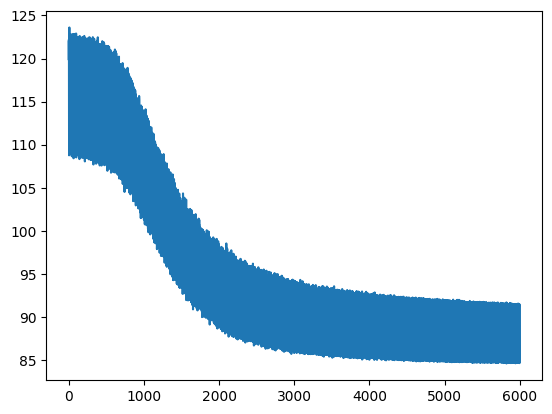

In [758]:
plt.plot(range(EPOCHS * 6), reconstruction_loss)

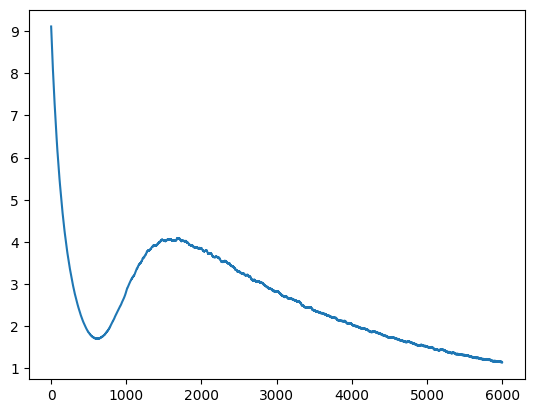

In [759]:
plt.plot(range(EPOCHS * 6), kl_loss)

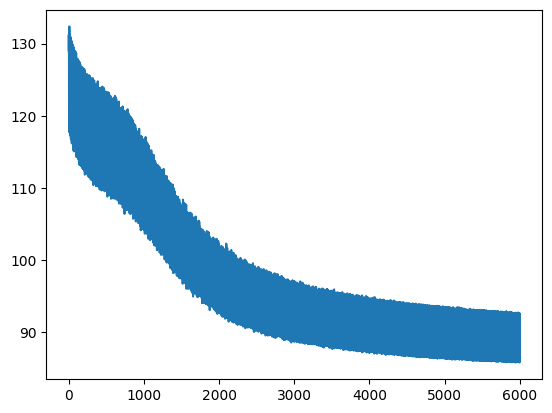

In [760]:
plt.plot(range(EPOCHS * 6), overall_loss)